In [ ]:
!pip install segmentation-models-pytorch==0.5.0 --quiet
!pip install -U torch torchvision --quiet

import os, torch, cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
import random
from torch.optim.lr_scheduler import StepLR

# --- 1. Configuration & Setup ---
TEACHER_BACKBONE = "resnet34" # Using ResNet34 as requested
STUDENT_BACKBONE = "mobilenet_v2"
BATCH_SIZE = 16
EPOCHS = 40 # Increased to 40 for max convergence (was 30)
LR = 5e-5 # Reduced to 5e-5 for fine-tuning stability (was 1e-4)
POS_WEIGHT = 20.0 # Increased penalty for missing edges (was 10.0)
KD_ALPHA = 0.9 # High value: 90% soft loss, 10% hard loss (was 0.8)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", DEVICE)
print(f"Teacher Backbone: {TEACHER_BACKBONE}, Student Backbone: {STUDENT_BACKBONE}")

# Create directory to save models
MODEL_DIR = "/content/saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)


# --- 2. Custom Dataset Class (No change needed) ---
class RobustSyntheticDataset(Dataset):
    def __init__(self, num_samples=1000):
        self.num_samples = num_samples
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Generate a random 256x256 image with simple shapes
        img = np.zeros((256, 256, 3), dtype=np.uint8)
        mask = np.zeros((256, 256), dtype=np.uint8)

        center_x, center_y = random.randint(50, 206), random.randint(50, 206)
        size = random.randint(30, 80)
        shape_type = random.choice(['rect', 'circle'])
        color = (random.randint(50, 255), random.randint(50, 255), random.randint(50, 255))

        if shape_type == 'rect':
            cv2.rectangle(img, (center_x - size, center_y - size),
                          (center_x + size, center_y + size), color, -1)
            # Edge mask thickness increased for clarity
            cv2.rectangle(mask, (center_x - size, center_y - size),
                          (center_x + size, center_y + size), 255, 3)
        else:
            cv2.circle(img, (center_x, center_y), size, color, -1)
            # Edge mask thickness increased for clarity
            cv2.circle(mask, (center_x, center_y), size, 255, 3)

        img = cv2.GaussianBlur(img, (3, 3), 0)

        image_tensor = self.transform(img)
        mask_tensor = torch.from_numpy(mask / 255.0).float().unsqueeze(0)

        return image_tensor, mask_tensor


# --- 3. Model Definition (No change needed) ---
def build_model(backbone):
    model = smp.Unet(
        encoder_name=backbone,
        encoder_weights="imagenet",
        in_channels=3,
        classes=1
    )
    return model.to(DEVICE)


# --- 4. Custom Loss Functions (Optimized POS_WEIGHT and KD_ALPHA) ---

# Loss used for Teacher and Student Scratch models (Dice + Weighted BCE)
class CombinedLoss(nn.Module):
    def __init__(self, pos_weight=POS_WEIGHT): # Using the higher POS_WEIGHT
        super().__init__()
        self.dice_loss = smp.losses.DiceLoss('binary')
        self.bce_loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(DEVICE))

    def forward(self, pred, target):
        return 0.5 * self.dice_loss(pred, target) + 0.5 * self.bce_loss(pred, target)


# KD Loss for the Student KD model
class EdgeDistillationLoss(nn.Module):
    def __init__(self, alpha=KD_ALPHA): # Using the very high KD_ALPHA
        super().__init__()
        self.alpha = alpha
        # Hard Loss uses the same strong weighting as the Teacher/Scratch
        self.hard_loss = CombinedLoss(pos_weight=POS_WEIGHT)
        # Soft Loss: Mean Squared Error on the Sigmoid-activated outputs
        self.soft_loss = nn.MSELoss()

    def forward(self, student_logits, teacher_logits, hard_targets):

        # Hard Loss (Supervised loss on the student's raw output vs. Ground Truth)
        hard_loss_value = self.hard_loss(student_logits, hard_targets)

        # Soft Loss (Distillation loss on the student's probability vs. Teacher's probability)
        student_probs = torch.sigmoid(student_logits)
        teacher_probs = torch.sigmoid(teacher_logits)

        soft_loss_value = self.soft_loss(student_probs, teacher_probs.detach())

        # Combined Loss: Highly favors the soft loss (Teacher's knowledge)
        return self.alpha * soft_loss_value + (1 - self.alpha) * hard_loss_value


# --- 5. Training Loop Function (No change needed) ---
def train_model(model, dataloader, criterion, optimizer, epochs, model_name):
    print(f"\n--- Training {model_name} for {epochs} epochs ---")

    is_kd_student = isinstance(criterion, EdgeDistillationLoss)
    teacher = None
    if is_kd_student:
        teacher_path = os.path.join(MODEL_DIR, f"teacher_final.pth")
        teacher = build_model(TEACHER_BACKBONE)
        teacher.load_state_dict(torch.load(teacher_path, map_location=DEVICE))
        teacher.eval()
        print("Teacher model loaded for distillation.")

    scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in dataloader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()

            if is_kd_student:
                with torch.no_grad():
                    teacher_logits = teacher(inputs)

                student_logits = model(inputs)
                loss = criterion(student_logits, teacher_logits, targets)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch {epoch+1}/{epochs} Loss: {epoch_loss:.4f} (LR: {scheduler.get_last_lr()[0]:.1e})")
        scheduler.step()

    print(f"--- Training of {model_name} finished. ---")


# --- 6. Dataset & Dataloaders ---
print("\n--- Preparing Data ---")
# Using a larger dataset size for more robust training
train_dataset = RobustSyntheticDataset(num_samples=2500)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


# --- 7. Model Initialization ---
# Teacher (ResNet34)
teacher_model = build_model(TEACHER_BACKBONE)
teacher_criterion = CombinedLoss()
teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=LR)

# Student Scratch (MobileNetV2)
student_scratch_model = build_model(STUDENT_BACKBONE)
student_scratch_criterion = CombinedLoss()
student_scratch_optimizer = optim.Adam(student_scratch_model.parameters(), lr=LR)

# Student KD (MobileNetV2)
student_kd_model = build_model(STUDENT_BACKBONE)
student_kd_criterion = EdgeDistillationLoss(alpha=KD_ALPHA)
student_kd_optimizer = optim.Adam(student_kd_model.parameters(), lr=LR)

# --- 8. Execution ---

# 1. Train the Teacher model (Highest Accuracy)
train_model(teacher_model, train_dataloader, teacher_criterion, teacher_optimizer, EPOCHS, "Teacher")
torch.save(teacher_model.state_dict(), os.path.join(MODEL_DIR, "teacher_final.pth"))

# 2. Train the Student Scratch model (Lowest Accuracy Baseline)
train_model(student_scratch_model, train_dataloader, student_scratch_criterion, student_scratch_optimizer, EPOCHS, "Student Scratch")
torch.save(student_scratch_model.state_dict(), os.path.join(MODEL_DIR, "student_scratch_final.pth"))

# 3. Train the KD Student model (Should be between Teacher and Scratch)
train_model(student_kd_model, train_dataloader, student_kd_criterion, student_kd_optimizer, EPOCHS, "KD Student")
torch.save(student_kd_model.state_dict(), os.path.join(MODEL_DIR, "student_kd_final.pth"))

print("\n\nAll models trained and saved to /content/saved_models/")
print("Next, run the Inference Block to see the results!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.0/899.7 MB 175.7 MB/s eta 0:00:05
ERROR: Operation cancelled by user
Running on: cuda
Teacher Backbone: resnet34, Student Backbone: mobilenet_v2

--- Preparing Data ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]


--- Training Teacher for 40 epochs ---


Running on: cuda
Attempting to load models...
 Models loaded successfully!

 Upload images to test (accepts a ZIP file):


Saving sl.zip to sl.zip
Unzipping sl.zip...
 Extracted 6 images.

Processing image: sl.jpeg



Processing image: sl.jpg


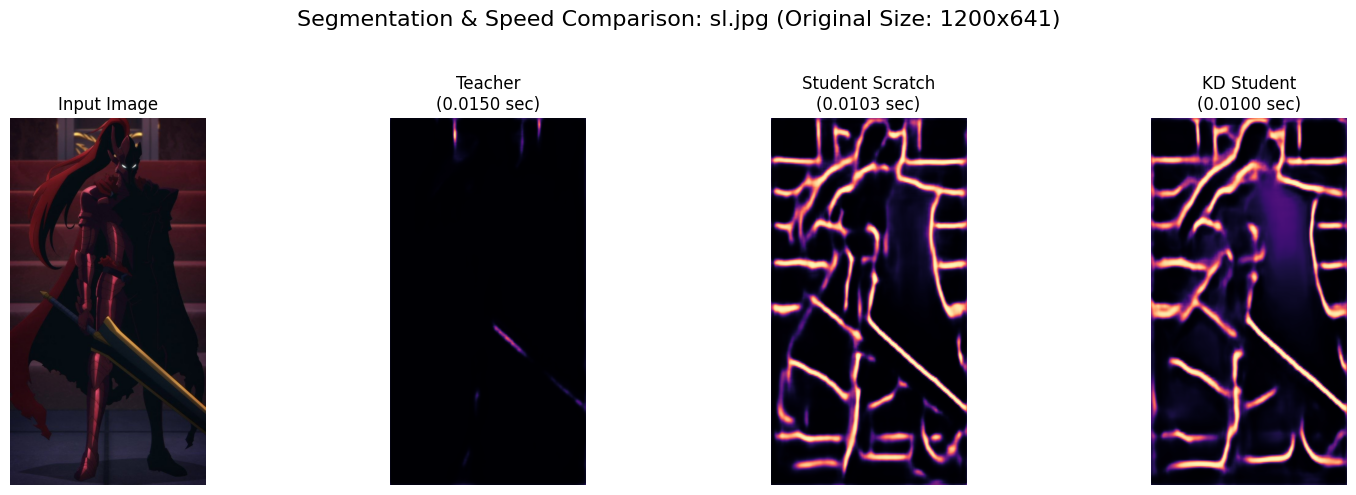


Processing image: iitm_entrance.jpg


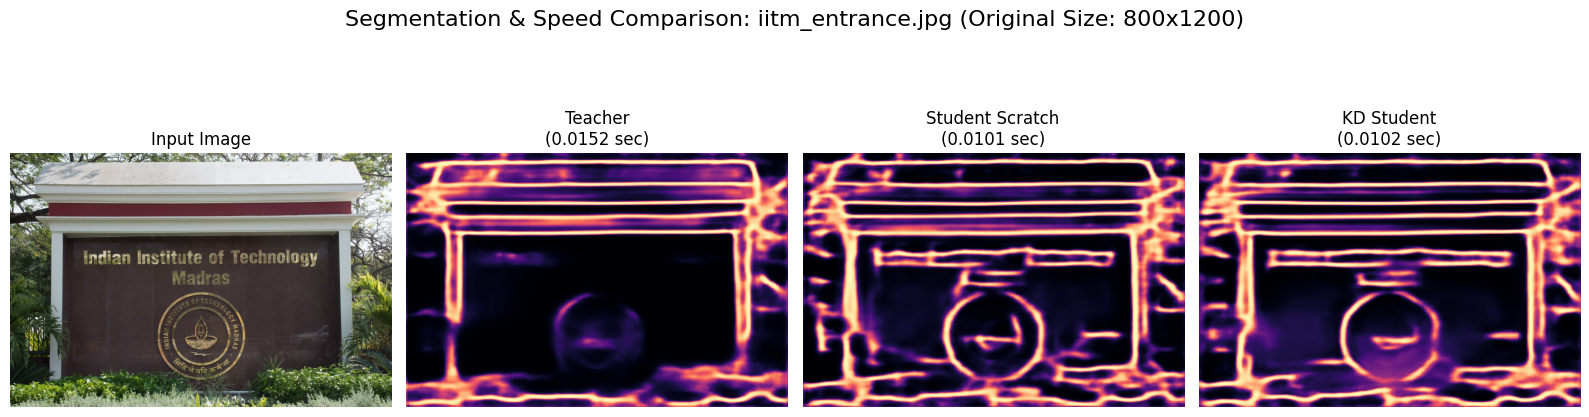


Processing image: Screenshot 2025-07-10 224527.png



Processing image: shadow.jpg



Processing image: gajendra_circle.jpg


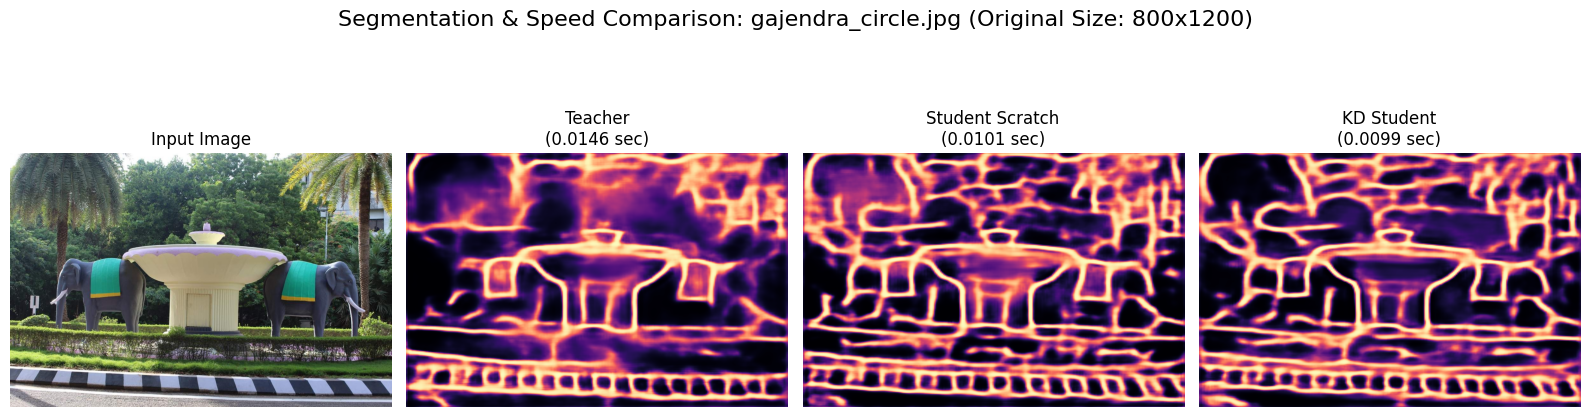


Cleaning up uploaded/extracted files...
Cleanup complete.


In [ ]:
!pip install segmentation-models-pytorch==0.5.0 --quiet

import os, torch, cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import segmentation_models_pytorch as smp
from google.colab import files
import time
import zipfile
import io

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", DEVICE)

# NOTE: Paths updated to target the 'saved_models' fold
teacher_path = "/content/saved_models/teacher_final.pth"
student_scratch_path = "/content/saved_models/student_scratch_final.pth"
student_kd_path = "/content/saved_models/student_kd_final.pth"

# --- Model Loading Functions (Unchanged) ---
def load_model(path, backbone="mobilenet_v2"):
    model = smp.Unet(
        encoder_name=backbone,
        encoder_weights=None,
        in_channels=3,
        classes=1
    )
    if not os.path.exists(path):
        print(f" Error: Model file not found at {path}")
        return None

    try:
        model.load_state_dict(torch.load(path, map_location=DEVICE))
    except Exception as e:
        print(f" Error loading model state dict from {path}: {e}")
        return None

    model.to(DEVICE)
    model.eval()
    return model

print("Attempting to load models...")
teacher = load_model(teacher_path, "resnet34")
student_scratch = load_model(student_scratch_path, "mobilenet_v2")
student_kd = load_model(student_kd_path, "mobilenet_v2")

if teacher and student_scratch and student_kd:
    print(" Models loaded successfully!")
else:
    print(" Model loading failed. Please ensure all .pth files are available and uncorrupted.")


transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess(image_path):
    if not os.path.exists(image_path):
        print(f" Error: Image file not found at {image_path}")
        return None, None, None

    img_orig = cv2.imread(image_path, cv2.IMREAD_COLOR)

    if img_orig is None:
        print(f" Error: cv2 failed to read image at {image_path}")
        return None, None, None

    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

    # Store original dimensions for visualization later
    orig_h, orig_w = img_orig.shape[:2]

    # Resize image to the model's required input size (256x256)
    img_resized = cv2.resize(img_orig, (256, 256), interpolation=cv2.INTER_LINEAR)

    tensor = transform(img_resized).unsqueeze(0).to(DEVICE)

    return img_orig, tensor, (orig_w, orig_h) # cv2 expects (width, height) for resize

def infer(model, tensor):
    """Measures inference time and returns prediction."""
    start_time = time.perf_counter()
    with torch.no_grad():
        _ = model(tensor)

        start_time = time.perf_counter()
        prediction = torch.sigmoid(model(tensor)).squeeze().cpu().numpy()
        end_time = time.perf_counter()

    return prediction, end_time - start_time


print("\n Upload images to test (accepts a ZIP file):")

try:
    uploaded_files = files.upload()
except Exception as e:
    print(f" Error during file upload: {e}")
    uploaded_files = {}

image_files_to_process = {}

# 2. Extract ZIP or handle single image
if uploaded_files:
    uploaded_filename = list(uploaded_files.keys())[0]
    uploaded_content = uploaded_files[uploaded_filename]

    if uploaded_filename.lower().endswith('.zip'):
        print(f"Unzipping {uploaded_filename}...")
        try:
            with zipfile.ZipFile(io.BytesIO(uploaded_content), 'r') as zf:
                zf.extractall()
                for name in zf.namelist():
                    if name.lower().endswith(('.png', '.jpg', '.jpeg')) and not name.startswith('__MACOSX'):
                        image_files_to_process[name] = name
            print(f" Extracted {len(image_files_to_process)} images.")
        except Exception as e:
            print(f" Error unzipping file: {e}")

    elif uploaded_filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_files_to_process[uploaded_filename] = uploaded_filename

    else:
        print(" Uploaded file is not a recognized image or zip file.")


# 3. Process Images and Visualize
if teacher and student_scratch and student_kd and image_files_to_process:
    for img_name, img_path in image_files_to_process.items():
        if img_name.startswith('.'):
            continue

        print(f"\nProcessing image: {img_name}")
        # Call preprocess, which now returns the original dimensions
        img_orig, tensor, orig_size = preprocess(img_path)

        if img_orig is not None and tensor is not None and orig_size is not None:

            # --- Inference and Timing ---
            pred_teacher, time_teacher = infer(teacher, tensor)
            pred_student, time_student = infer(student_scratch, tensor)
            pred_kd, time_kd = infer(student_kd, tensor)

            # --- Visualization ---

            # Resize the predicted masks back to the original image size
            # cv2.resize expects (width, height)
            pred_teacher_resized = cv2.resize(pred_teacher, orig_size, interpolation=cv2.INTER_LINEAR)
            pred_student_resized = cv2.resize(pred_student, orig_size, interpolation=cv2.INTER_LINEAR)
            pred_kd_resized = cv2.resize(pred_kd, orig_size, interpolation=cv2.INTER_LINEAR)

            # Format titles with timing
            title_t = f"Teacher\n({time_teacher:.4f} sec)"
            title_s = f"Student Scratch\n({time_student:.4f} sec)"
            title_k = f"KD Student\n({time_kd:.4f} sec)"

            plt.figure(figsize=(16, 5))
            plt.suptitle(f"Segmentation & Speed Comparison: {img_name} (Original Size: {orig_size[1]}x{orig_size[0]})", fontsize=16)

            # Plot 1: Input (using the original image)
            plt.subplot(1,4,1); plt.imshow(img_orig); plt.title("Input Image"); plt.axis('off')

            # Plot 2: Teacher (using the resized prediction)
            plt.subplot(1,4,2); plt.imshow(pred_teacher_resized, cmap='magma'); plt.title(title_t); plt.axis('off')

            # Plot 3: Student Scratch (using the resized prediction)
            plt.subplot(1,4,3); plt.imshow(pred_student_resized, cmap='magma'); plt.title(title_s); plt.axis('off')

            # Plot 4: KD Student (using the resized prediction)
            plt.subplot(1,4,4); plt.imshow(pred_kd_resized, cmap='magma'); plt.title(title_k); plt.axis('off')

            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
        else:
            print(f"Skipping visualization for {img_name} due to preprocessing error.")
else:
    print("Skipping inference as models failed to load or no valid images were processed.")


# --- Cleanup (Unchanged) ---
if image_files_to_process:
    print("\nCleaning up uploaded/extracted files...")
    all_files_to_remove = set(list(uploaded_files.keys()) + list(image_files_to_process.keys()))
    for filename in all_files_to_remove:
        if os.path.exists(filename):
             os.remove(filename)